This formulation enforces that dphi/dr = sin(theta) at the "vertical" surface when integrating.

In [1]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
import numpy as np
from multi_condensed import Problem
from math import sqrt, cosh, cos, sinh, sin, pi, exp
from scipy import integrate
import time

from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import ive as besselie
from scipy.special import kve as besselke
from numpy import inf

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [2]:
# Operate on the configuration defined in visual_potential_comparison, for an easy visual check on correctness.
# Try it with varying resolutions (10, 20, 30, 40, 50).

h = 50
a = [4, 9]
d_in = [30, 30]
d_out = [30, 5]
heaving = [0, 1]
m0 = 1
rho = 1023

In [3]:
class SProblem1(Problem):
    def __init__(self, h, d, a, heaving, NMK, m0, rho, slopes, scale = None):
        self.h = h
        self.d = d
        self.a = a
        self.heaving = heaving
        self.NMK = NMK
        self.m0 = m0
        self.rho = rho
        self.scale = a if scale is None else scale
        self.size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
        self.boundary_count = len(NMK) - 1
        self.m_k = self.m_k_array()
        self.slopes = slopes
        self.thetas = self.get_angles()
    
    def get_angles(self):
        def arccot(x):
            if x == 0: return np.pi/2
            else: return np.atan(1/x)
        return [arccot(slope) for slope in self.slopes]

    def det_region(self, r):
        region = 0
        for i in range(self.boundary_count):
            if r <= self.a[i]:
                return region
            else: region += 1
        return region
    
    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving

        if d[i] > d[i + 1]:
            tall = i + 1 # tall fluid
            short = i # short fluid
        else:
            tall = i
            short = i + 1

        if self.slopes[tall] == 0: # slope of vertical surface is infinite
            sin_theta = 0
        else: # use slope of slant for "vertical" surface
            sin_theta = np.sin(self.thetas[tall])
      
        if n == 0:
            slant_correction = sin_theta * (d[i] - d[i + 1])
            return (heaving[i+1] - heaving[i]) * (a[i]/2) + slant_correction
        
        slant_correction = - sin_theta * sqrt(2) * sin(self.lambda_ni(n, tall) * (h - d[short])) / self.lambda_ni(n, tall)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1) * (h-d[i]))
                denom = (2 * (h - d[i]) * self.lambda_ni(n, i+1))
                return num/denom + slant_correction
            else: return 0 + slant_correction
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i) * (h-d[i+1]))
                denom = (2 * (h - d[i+1]) * self.lambda_ni(n, i))
                return num/denom + slant_correction
            else: return 0 + slant_correction

    # No change to velocity end entry

In [4]:
# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError
  
  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
        slopes.append(0)
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       slope = (d_in[i]-d_out[i])/(a[i] - a[i - 1]) # better edit needed for sloped innermost region
       slopes += ([slope] * res)
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime, slopes

In [ ]:
def solve_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version):
  NMK = [150, 150, 150]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return x, cs, prob

def plot_both(prob, cs):
  prob.plot_potentials(cs, res = 400)
  prob.plot_velocities(cs, res = 400)

In [6]:
x1, cs1, p1 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 1)
x2, cs2, p2 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 2)
x3, cs3, p3 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 3)

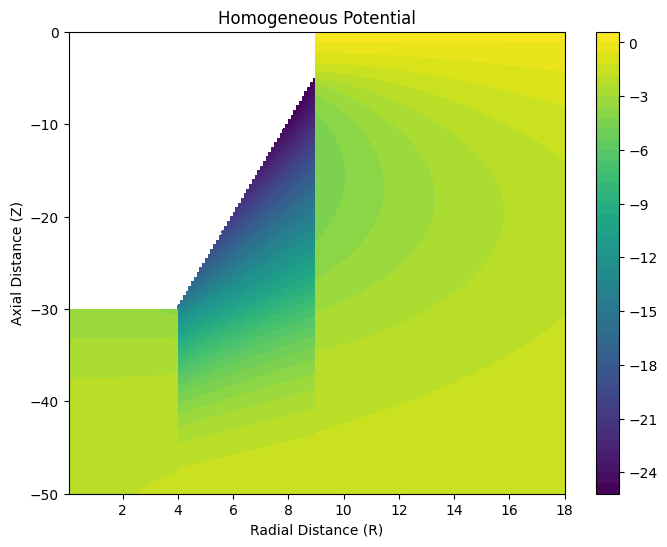

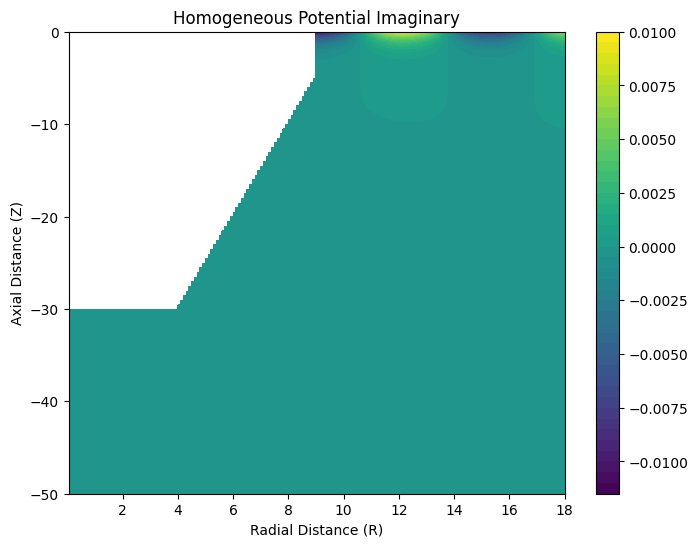

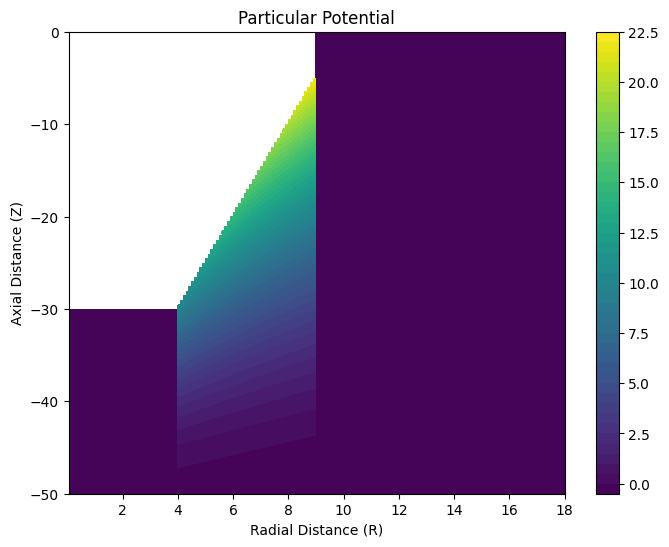

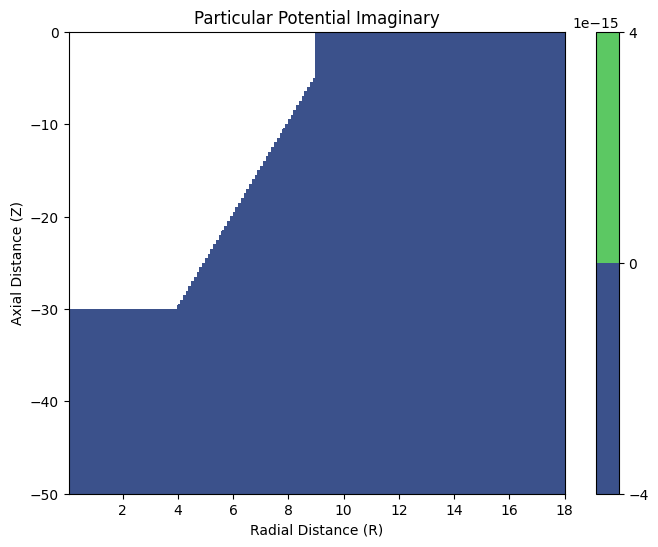

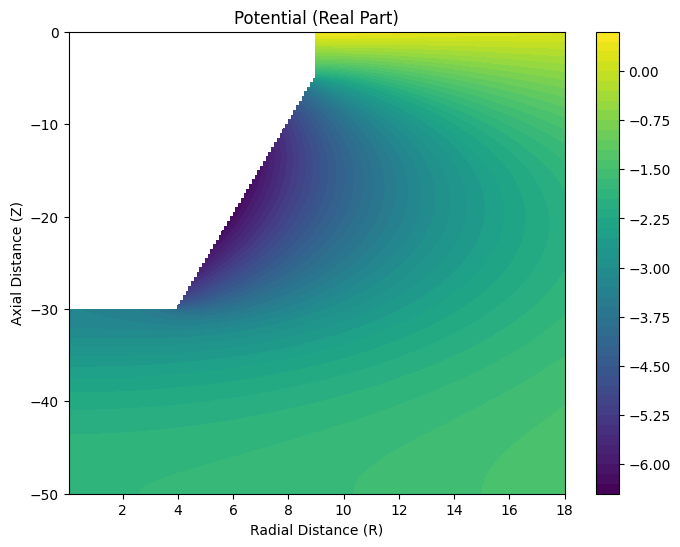

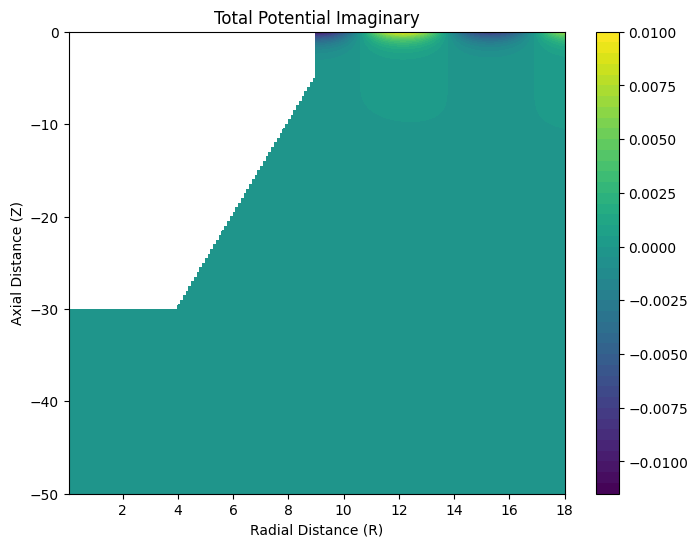

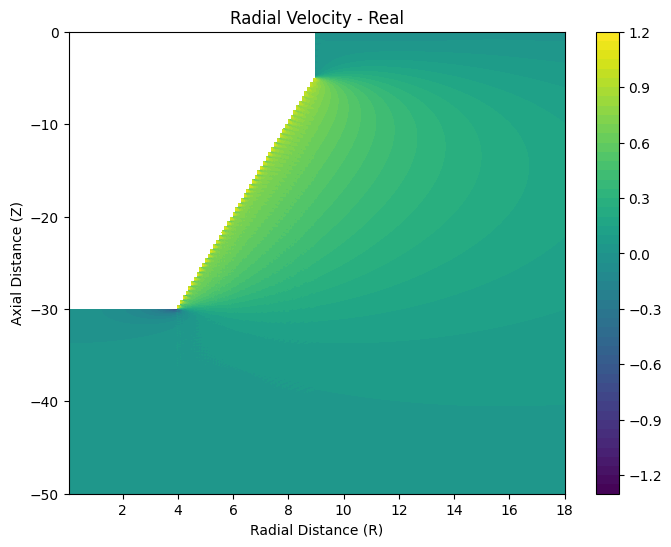

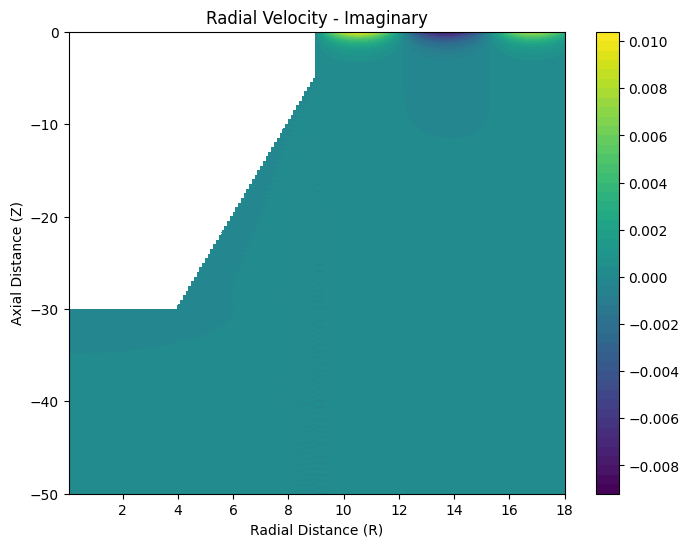

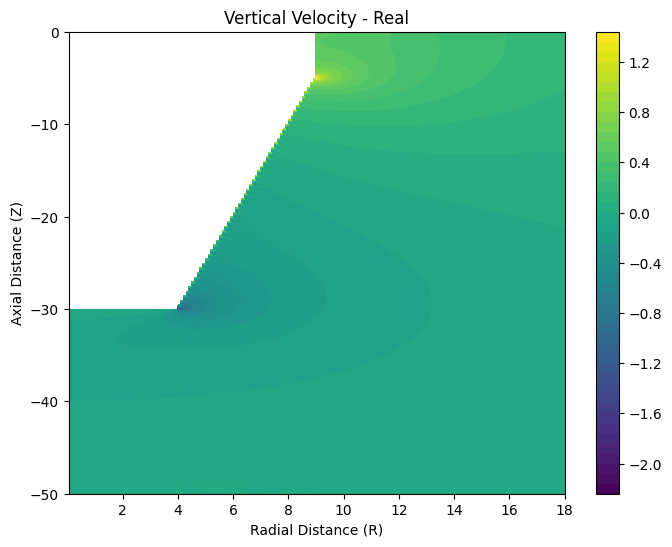

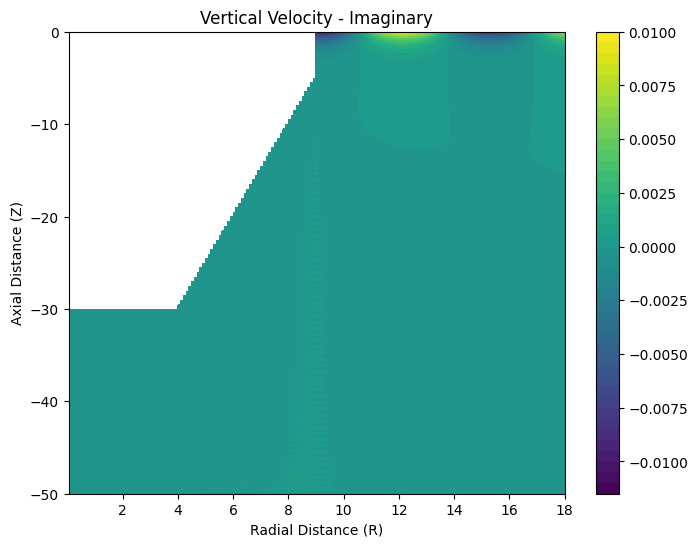

In [ ]:
# plot_both(p1, cs1)

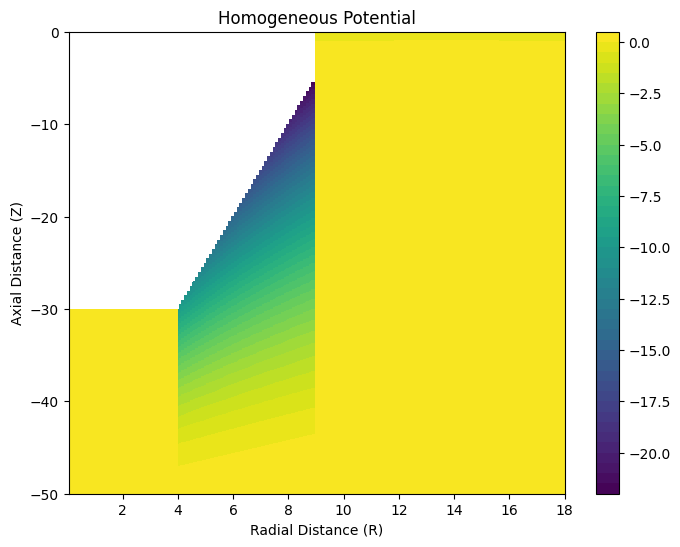

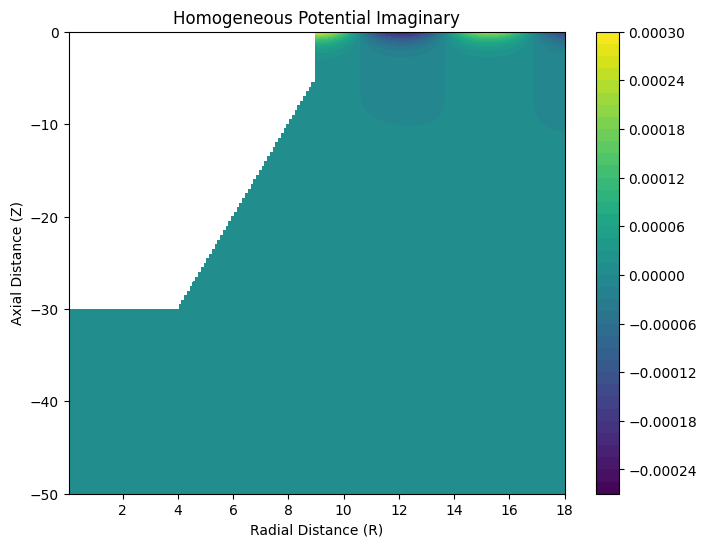

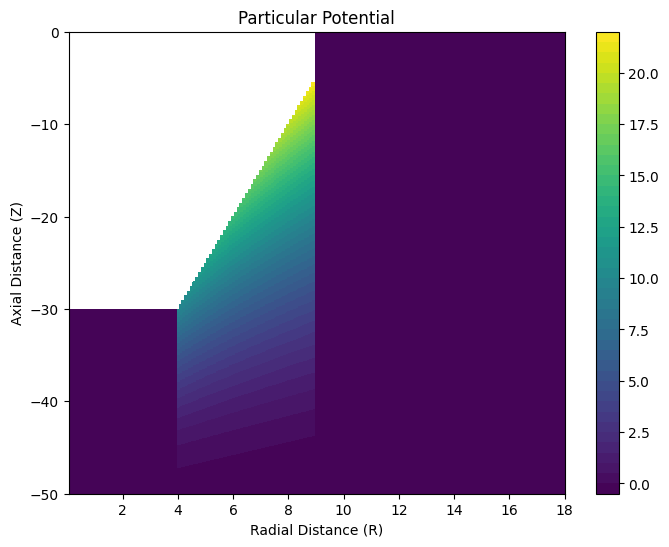

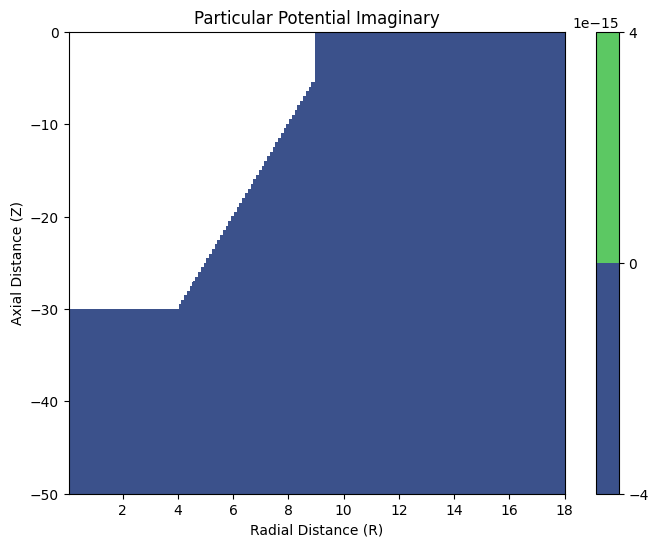

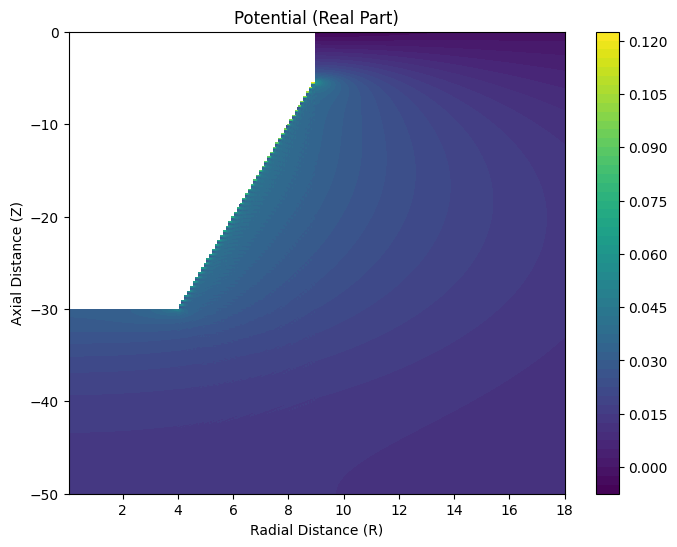

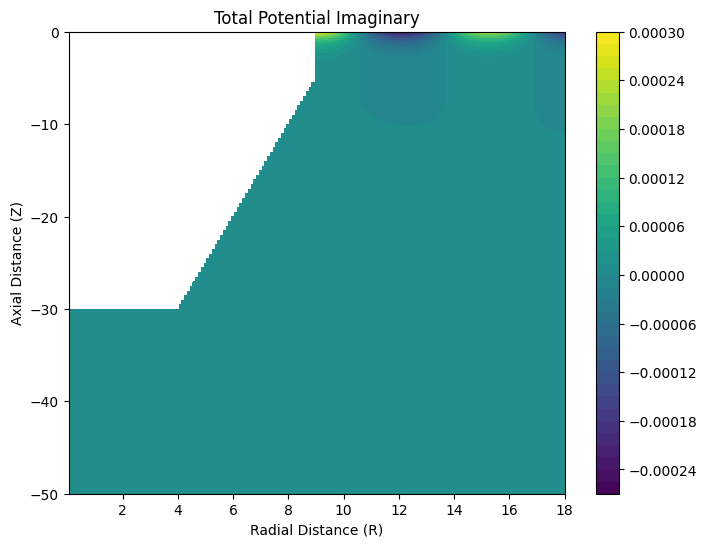

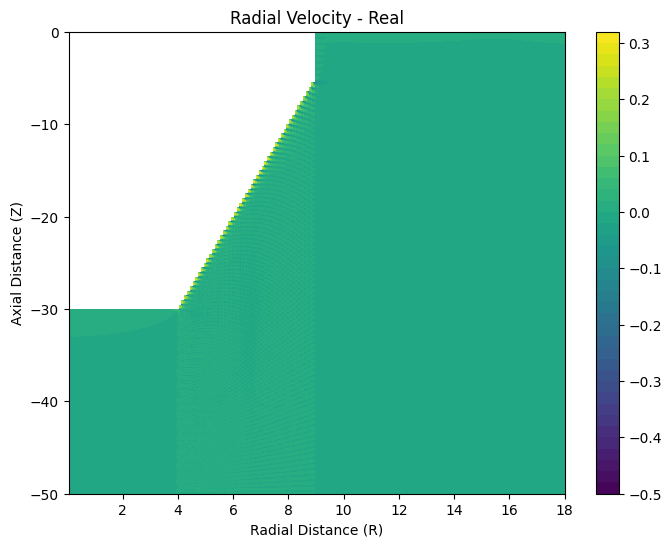

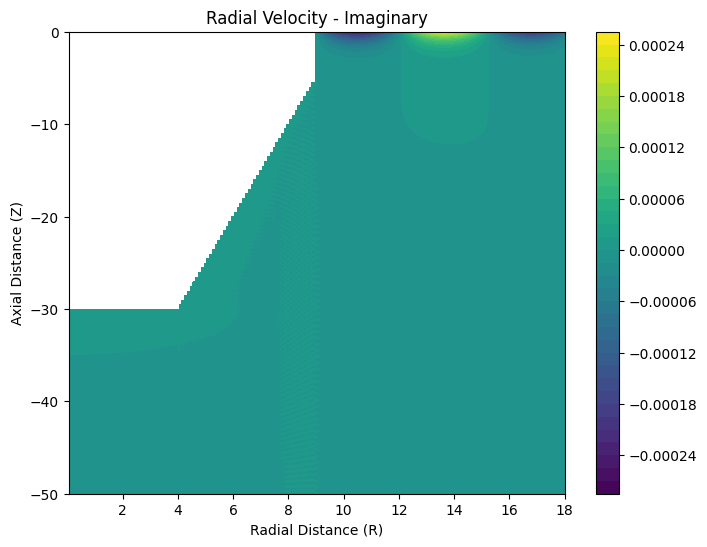

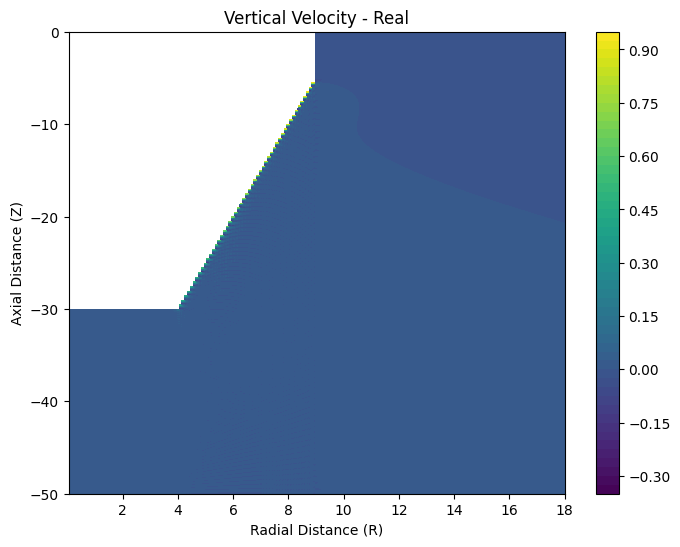

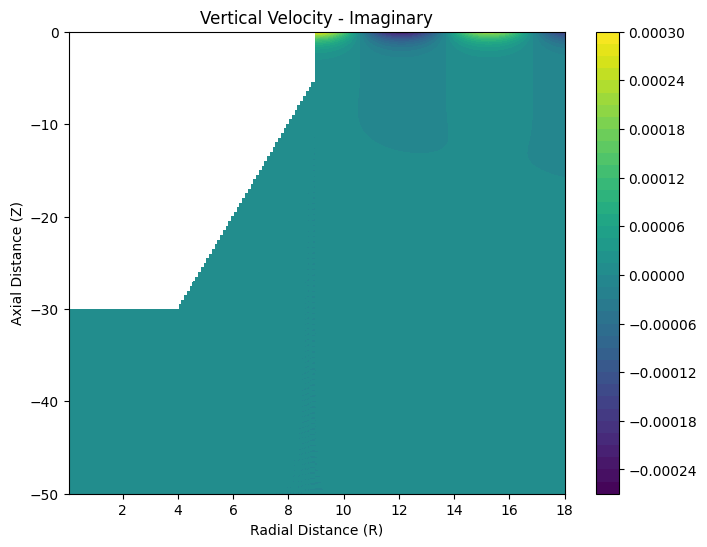

In [7]:
plot_both(p2, cs2)

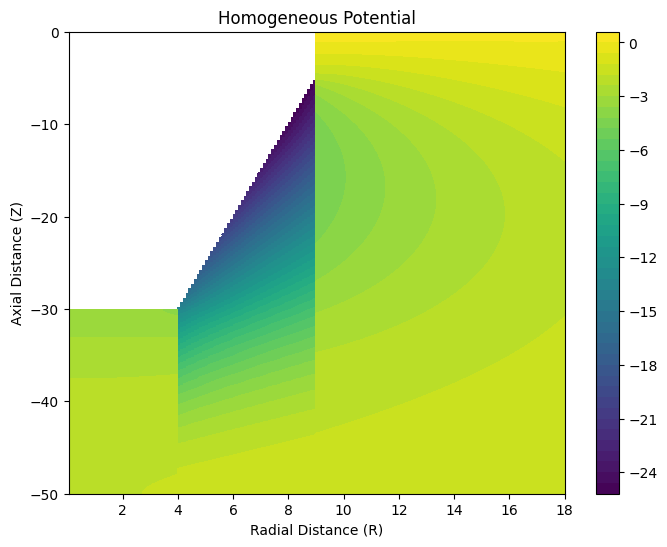

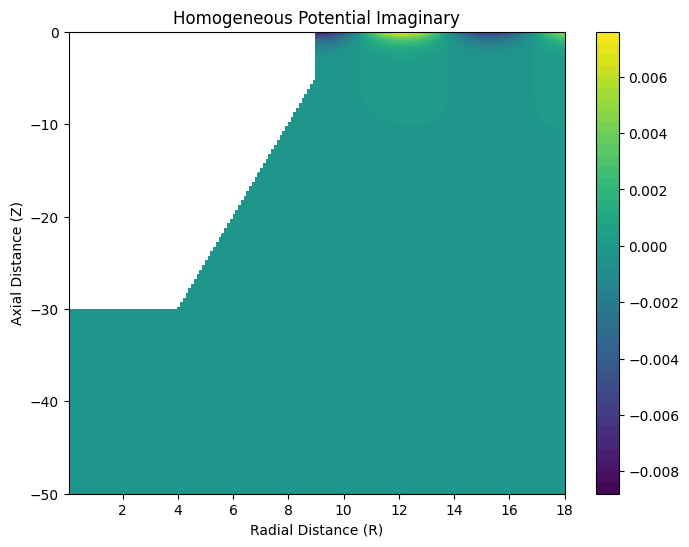

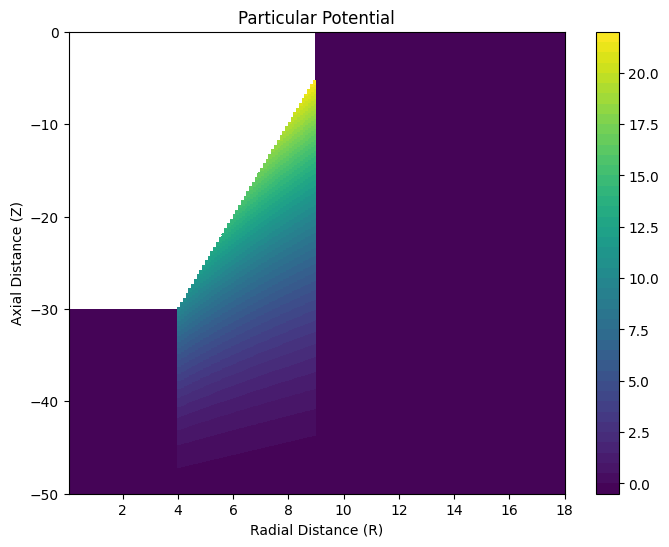

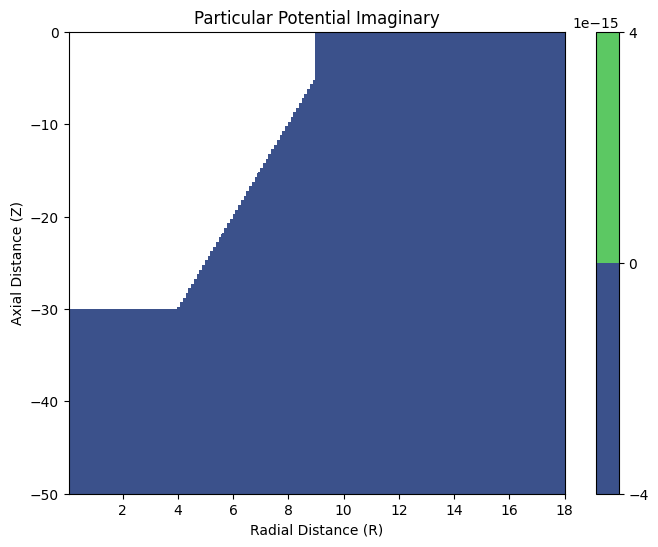

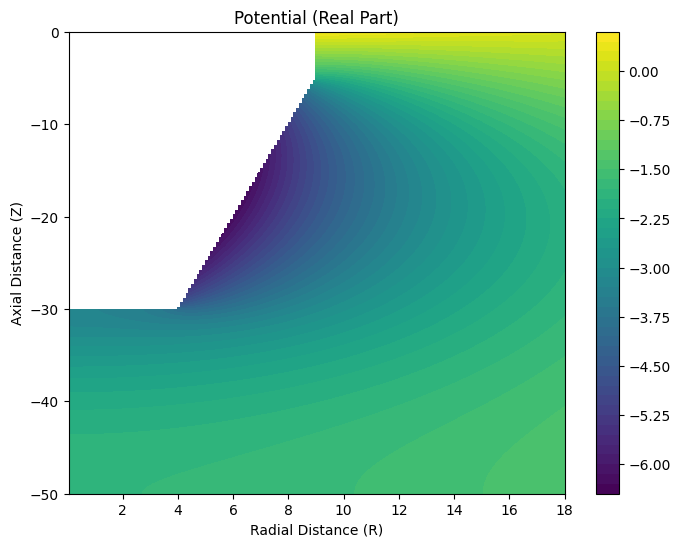

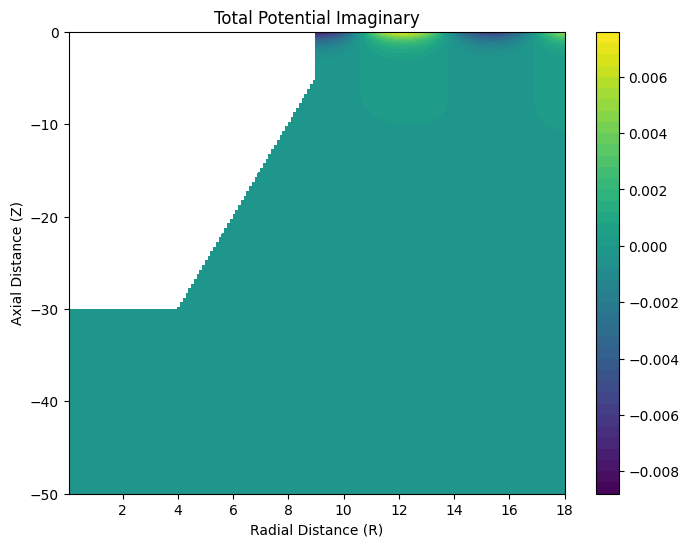

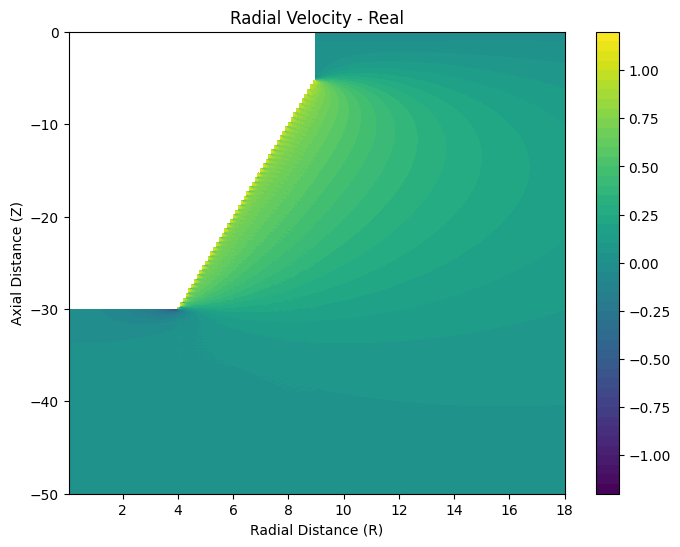

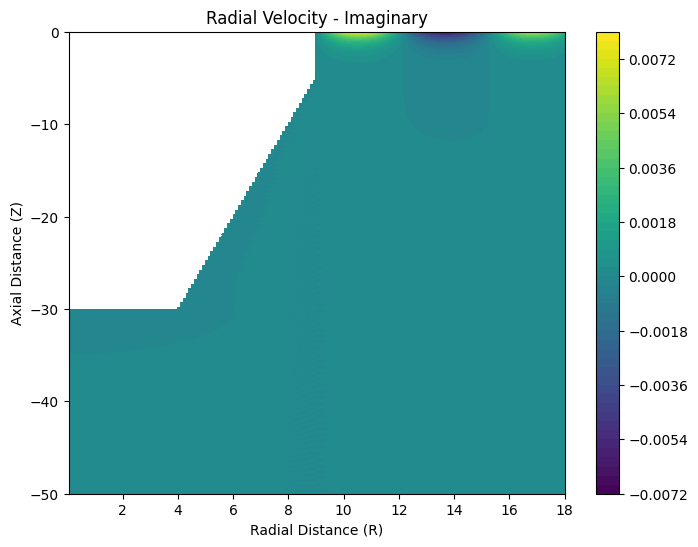

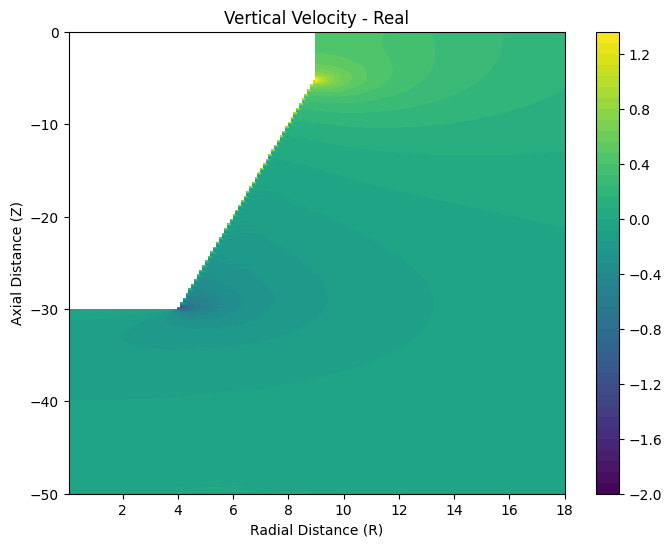

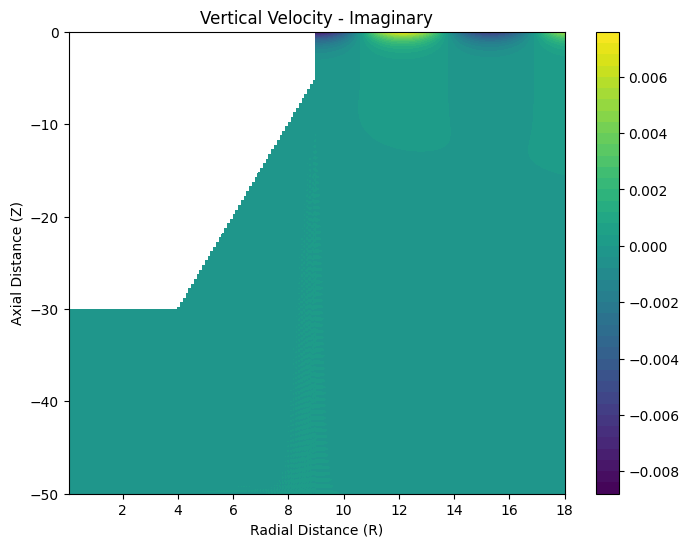

In [ ]:
# plot_both(p3, cs3)

In [18]:
class PotentialProblem(Problem):
  def det_region(self, r):
    region = 0
    for i in range(self.boundary_count):
        if r <= self.a[i]:
            return region
        else: region += 1
    return region
  
  def phi_p_i(self, r, z, i): # particular solution
      return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
  
  def potential(self, r, z, cs):
    region = self.det_region(r)
    nmk = self.NMK[region]
    nmks = list(range(nmk))
    if region == self.boundary_count: # Outermost
      lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
      z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
      return np.dot(cs[-1], lambda_vals * z_vals)
    else:
      phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
      r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
      z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
      phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
      if region == 0: # Innermost
        return phi_p + phi_h_1
      else: # Typical region
        r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
        phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
        return phi_p + phi_h_1 + phi_h_2

In [19]:
def outline_function(r):
  region = 0
  for rad in a:
    if r <= rad: break
    else: region += 1
  if region == len(a): return 0
  elif d_in[region] == d_out[region]:
    return - d_in[region]
  else:
    inner_rad = 0 if region == 0 else a[region - 1]
    outer_rad = a[region]
    slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
    return slope * (r - inner_rad) - d_in[region]

def plot_contour(prob, cs, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return prob.potential(r, z, cs)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z)

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('Contour Map')
    plt.show()

def construct_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version):
  NMK = [150, 150, 150]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  return prob

Try this, but scale the particular solution by sin(theta) (or cos(theta)).

In [21]:
class SProblem2(SProblem1):
    def p_scale(self, i):
        if self.slopes[i] == 0:
            return 1
        else: return np.sin(self.thetas[i])

    def b_potential_entry(self, n, i): # for two i-type regions
        #(integrate over shorter fluid, use shorter fluid eigenfunction)
        h, d, a, heaving = self.h, self.d, self.a, self.heaving
        j = i + (d[i] <= d[i+1]) # index of shorter fluid
        constant = (self.p_scale(i+1) * heaving[i+1] / (h - d[i+1]) - self.p_scale(i) * heaving[i] / (h - d[i]))
        if n == 0:
            return constant * 1/2 * ((h - d[j])**3/3 - (h-d[j]) * a[i]**2/2)
        else:
            return sqrt(2) * (h - d[j]) * constant * ((-1) ** n)/(self.lambda_ni(n, j) ** 2)

    def b_potential_end_entry(self, n, i): # between i and e-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving
        constant = - heaving[i] / (h - d[i]) * self.p_scale(i)
        if n == 0:
            return constant * 1/2 * ((h - d[i])**3/3 - (h-d[i]) * a[i]**2/2)
        else:
            return sqrt(2) * (h - d[i]) * constant * ((-1) ** n)/(self.lambda_ni(n, i) ** 2)
        
    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving

        if d[i] > d[i + 1]:
            tall = i + 1 # tall fluid
            short = i # short fluid
        else:
            tall = i
            short = i + 1

        if self.slopes[tall] == 0:
            sin_theta = 0
        else:
            sin_theta = np.sin(self.thetas[tall])
      
        if n == 0:
            slant_correction = sin_theta * (d[short] - d[tall])
            return (self.p_scale(i + 1) * heaving[i+1] - self.p_scale(i) * heaving[i]) * (a[i]/2) + slant_correction
        
        slant_correction = - sin_theta * sqrt(2) * sin(self.lambda_ni(n, tall) * (h - d[short])) / self.lambda_ni(n, tall)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1) * (h-d[i])) * self.p_scale(i)
                denom = (2 * (h - d[i]) * self.lambda_ni(n, i+1))
                return num/denom + slant_correction
            else: return 0 + slant_correction
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i) * (h-d[i+1])) * self.p_scale(i+1)
                denom = (2 * (h - d[i+1]) * self.lambda_ni(n, i))
                return num/denom + slant_correction
            else: return 0 + slant_correction

    def b_velocity_end_entry(self, k, i): # between i and e-type regions
        h, d, a, heaving, m0, m_k = self.h, self.d, self.a, self.heaving, self.m0, self.m_k
        constant = - self.p_scale(i) * heaving[i] * a[i]/(2 * (h - d[i]))
        if k == 0:
            if m0 == inf: return 0
            elif m0 * h < 14:
                return constant * (1/sqrt(self.N_k(0))) * sinh(m0 * (h - d[i])) / m0
            else: # high m0h approximation
                return constant * sqrt(2 * h / m0) * (exp(- m0 * d[i]) - exp(m0 * d[i] - 2 * m0 * h))
        else:
            return constant * (1/sqrt(self.N_k(k))) * sin(m_k[k] * (h - d[i])) / m_k[k]

    def generate_potential_plot_array(self, cs, res):
        h, d, a, heaving, NMK = self.h, self.d, self.a, self.heaving, self.NMK
        R_1n, R_2n, Lambda_k= self.R_1n, self.R_2n, self.Lambda_k
        Z_n_i, Z_k_e = self.Z_n_i, self.Z_k_e

        def phi_h_n_inner_func(n, r, z):
            return (cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)
        def phi_h_m_i_func(i, m, r, z):
            return (cs[i][m] * R_1n(m, r, i) + cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i)
        def phi_e_k_func(k, r, z):
            return cs[-1][k] * Lambda_k(k, r) * Z_k_e(k, z)
        def phi_p_i(i, r, z): # particular solution
            return (1 / (2* (h - d[i]))) * ((z + h) ** 2 - (r**2) / 2) * self.p_scale(i)

        phi_e_k_vec = np.vectorize(phi_e_k_func, otypes = [complex])
        phi_h_n_inner_vec = np.vectorize(phi_h_n_inner_func, otypes = [complex])
        phi_h_m_i_vec = np.vectorize(phi_h_m_i_func, otypes = [complex])
        phi_p_i_vec = np.vectorize(phi_p_i)

        R, Z = self.make_R_Z(True, res)

        regions = []
        regions.append((R <= a[0]) & (Z < -d[0]))
        for i in range(1, self.boundary_count):
            regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
        regions.append(R > a[-1])

        phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
        phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
        phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

        for n in range(NMK[0]):
            temp_phiH = phi_h_n_inner_vec(n, R[regions[0]], Z[regions[0]])
            phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

        for i in range(1, self.boundary_count):
            for m in range(NMK[i]):
                temp_phiH = phi_h_m_i_vec(i, m, R[regions[i]], Z[regions[i]])
                phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

        for k in range(NMK[-1]):
            temp_phiH = phi_e_k_vec(k, R[regions[-1]], Z[regions[-1]])
            phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

        phiP[regions[0]] = heaving[0] * phi_p_i_vec(0, R[regions[0]], Z[regions[0]])
        for i in range(1, self.boundary_count):
            phiP[regions[i]] = heaving[i] * phi_p_i_vec(i, R[regions[i]], Z[regions[i]])
        phiP[regions[-1]] = 0

        phi = phiH + phiP
        return phi, phiH, phiP

    def generate_velocity_plot_array(self, cs, res):
        h, d, a, heaving, NMK = self.h, self.d, self.a, self.heaving, self.NMK
        R_1n, R_2n, Lambda_k= self.R_1n, self.R_2n, self.Lambda_k
        diff_R_1n, diff_R_2n, diff_Lambda_k= self.diff_R_1n, self.diff_R_2n, self.diff_Lambda_k
        Z_n_i, Z_k_e = self.Z_n_i, self.Z_k_e
        diff_Z_n_i, diff_Z_k_e = self.diff_Z_n_i, self.diff_Z_k_e

        def diff_r_phi_p_i(i, r, z):
            return (- r / (2* (h - d[i]))) * self.p_scale(i)
        def diff_z_phi_p_i(i, r, z): 
            return ((z+h) / (h - d[i])) * self.p_scale(i)
        def v_r_inner_func(n, r, z):
            return (cs[0][n] * diff_R_1n(n, r, 0)) * Z_n_i(n, z, 0)
        def v_r_m_i_func(i, m, r, z):
            return (cs[i][m] * diff_R_1n(m, r, i) + cs[i][NMK[i] + m] * diff_R_2n(m, r, i)) * Z_n_i(m, z, i)
        def v_r_e_k_func(k, r, z):
            return cs[-1][k] * diff_Lambda_k(k, r) * Z_k_e(k, z)
        def v_z_inner_func(n, r, z):
            return (cs[0][n] * R_1n(n, r, 0)) * diff_Z_n_i(n, z, 0)
        def v_z_m_i_func(i, m, r, z):
            return (cs[i][m] * R_1n(m, r, i) + cs[i][NMK[i] + m] * R_2n(m, r, i)) * diff_Z_n_i(m, z, i)
        def v_z_e_k_func(k, r, z):
            return cs[-1][k] * Lambda_k(k, r) * diff_Z_k_e(k, z)

        vr_p_i_vec = np.vectorize(diff_r_phi_p_i)
        vz_p_i_vec = np.vectorize(diff_z_phi_p_i)
        v_r_inner_vec = np.vectorize(v_r_inner_func, otypes = [complex])
        v_r_m_i_vec = np.vectorize(v_r_m_i_func, otypes = [complex])
        v_r_e_k_vec = np.vectorize(v_r_e_k_func, otypes = [complex])
        v_z_inner_vec = np.vectorize(v_z_inner_func, otypes = [complex])
        v_z_m_i_vec = np.vectorize(v_z_m_i_func, otypes = [complex])
        v_z_e_k_vec = np.vectorize(v_z_e_k_func, otypes = [complex])

        R, Z = self.make_R_Z(True, res)

        regions = []
        regions.append((R <= a[0]) & (Z < -d[0]))
        for i in range(1, self.boundary_count):
            regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
        regions.append(R > a[-1])

        vrH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
        vrP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
        vzH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
        vzP = np.full_like(R, np.nan + np.nan*1j, dtype=complex)

        for n in range(NMK[0]):
            temp_vrH = v_r_inner_vec(n, R[regions[0]], Z[regions[0]])
            temp_vzH = v_z_inner_vec(n, R[regions[0]], Z[regions[0]])
            if n == 0:
                vrH[regions[0]] = temp_vrH
                vzH[regions[0]] = temp_vzH
            else:
                vrH[regions[0]] = vrH[regions[0]] + temp_vrH
                vzH[regions[0]] = vzH[regions[0]] + temp_vzH

        for i in range(1, self.boundary_count):
            for m in range(NMK[i]):
                temp_vrH = v_r_m_i_vec(i, m, R[regions[i]], Z[regions[i]])
                temp_vzH = v_z_m_i_vec(i, m, R[regions[i]], Z[regions[i]])
                if m == 0:
                    vrH[regions[i]] = temp_vrH
                    vzH[regions[i]] = temp_vzH
                else:
                    vrH[regions[i]] = vrH[regions[i]] + temp_vrH
                    vzH[regions[i]] = vzH[regions[i]] + temp_vzH

        for k in range(NMK[-1]):
            temp_vrH = v_r_e_k_vec(k, R[regions[-1]], Z[regions[-1]])
            temp_vzH = v_z_e_k_vec(k, R[regions[-1]], Z[regions[-1]])
            if k == 0:
                vrH[regions[-1]] = temp_vrH
                vzH[regions[-1]] = temp_vzH
            else:
                vrH[regions[-1]] = vrH[regions[-1]] + temp_vrH
                vzH[regions[-1]] = vzH[regions[-1]] + temp_vzH

        vrP[regions[0]] = heaving[0] * vr_p_i_vec(0, R[regions[0]], Z[regions[0]])
        vzP[regions[0]] = heaving[0] * vz_p_i_vec(0, R[regions[0]], Z[regions[0]])
        for i in range(1, self.boundary_count):
            vrP[regions[i]] = heaving[i] * vr_p_i_vec(i, R[regions[i]], Z[regions[i]])
            vzP[regions[i]] = heaving[i] * vz_p_i_vec(i, R[regions[i]], Z[regions[i]])
        vrP[regions[-1]] = 0
        vzP[regions[-1]] = 0

        vr = vrH + vrP
        vz = vzH + vzP

        return vr, vz

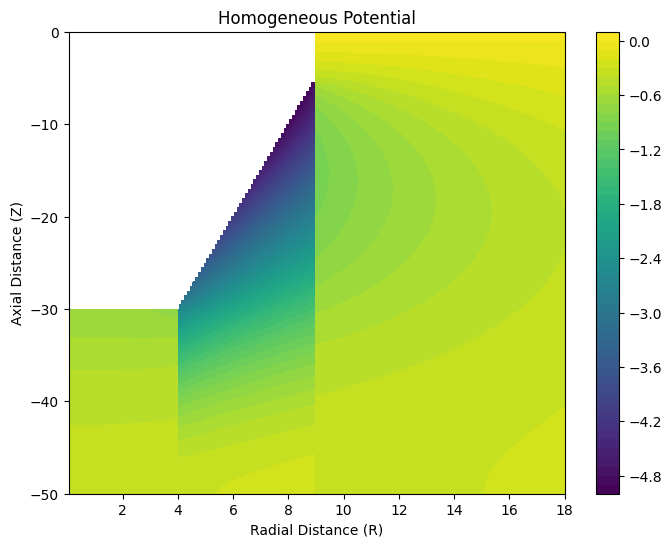

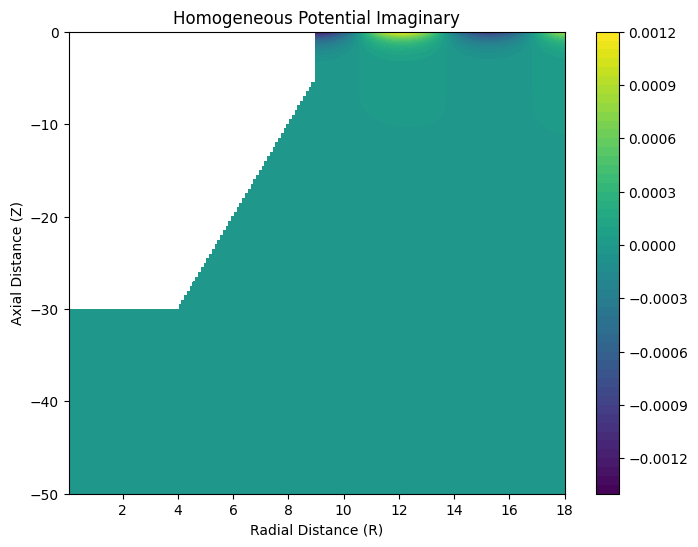

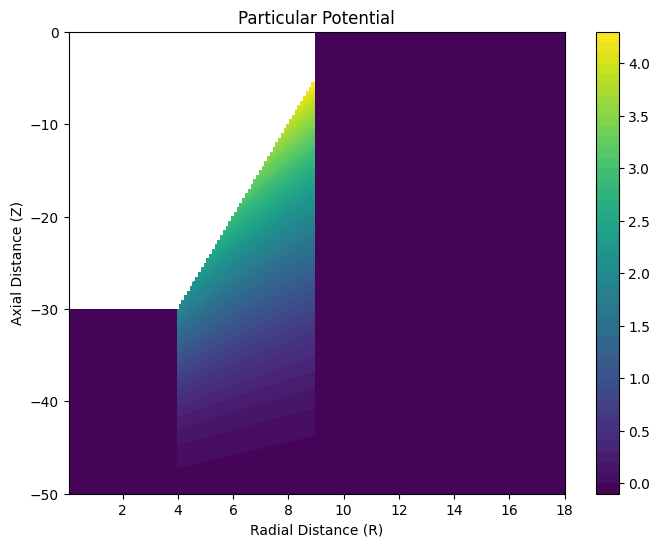

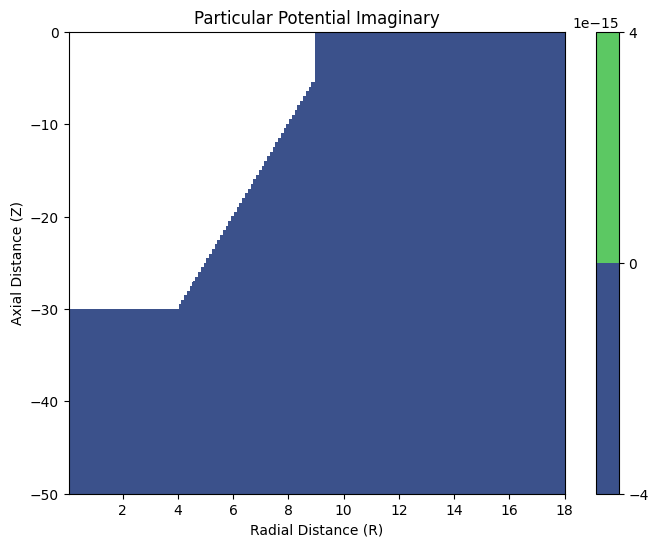

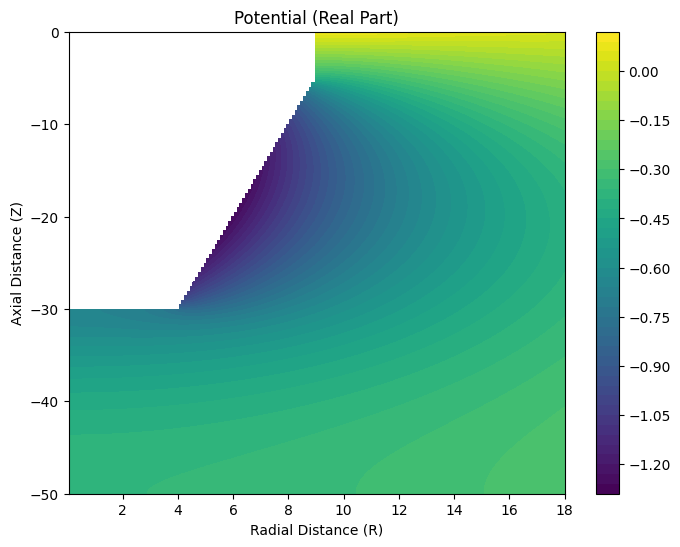

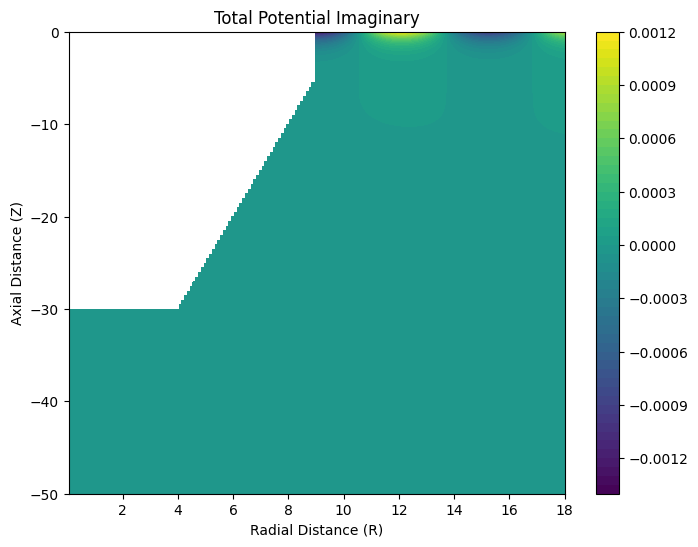

In [22]:
x4, cs4, p4 = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 50, 2)
p4.plot_potentials(cs4, res = 400)

In [23]:
class SProblem3(SProblem2):
    def p_scale(self, i):
      if self.slopes[i] == 0:
          return 1
      else: return np.cos(self.thetas[i])

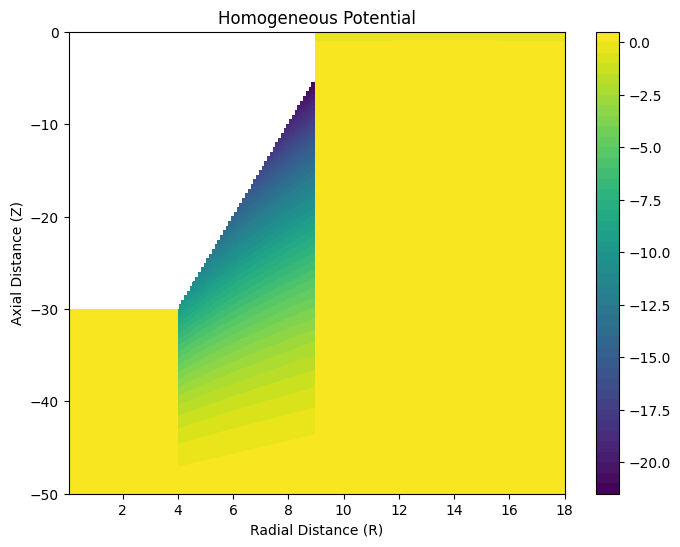

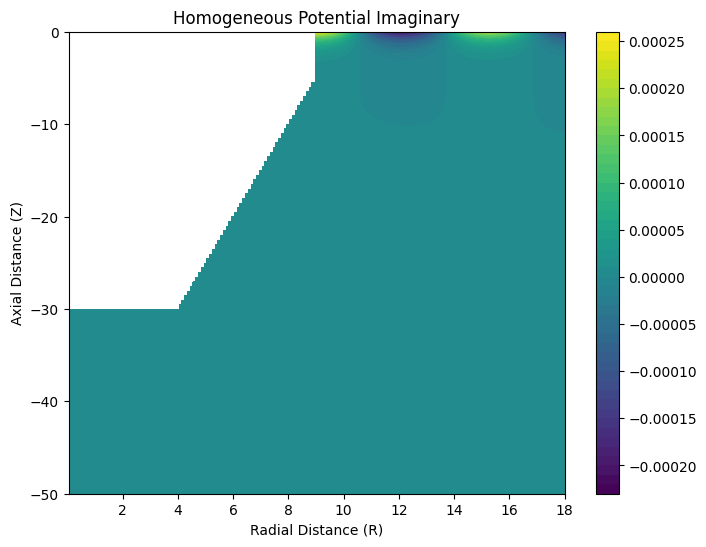

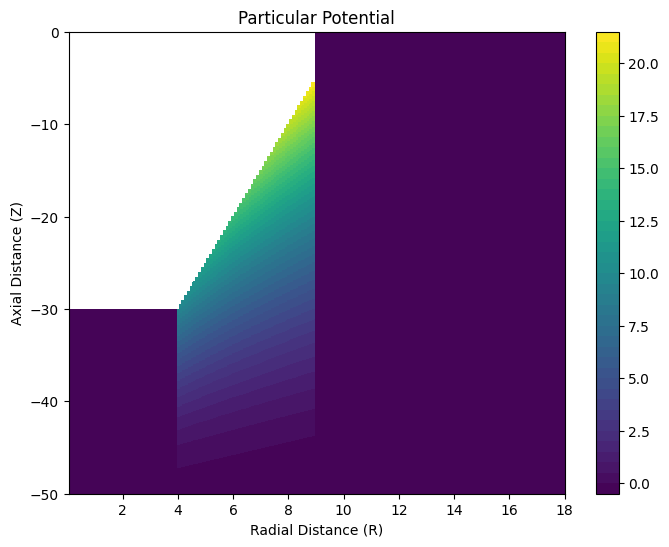

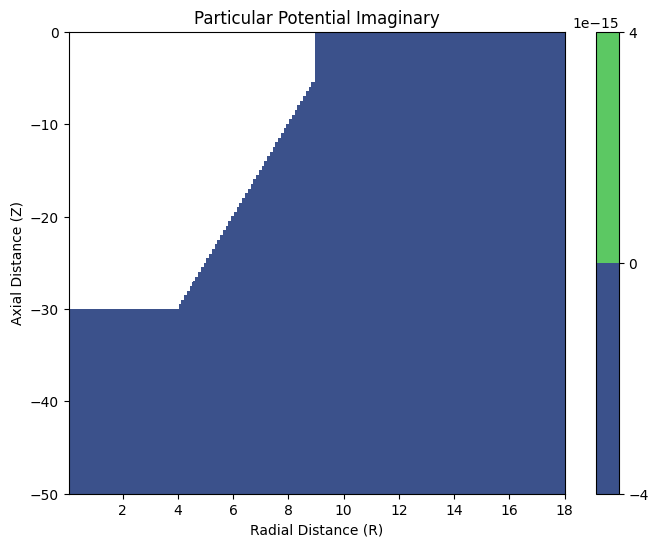

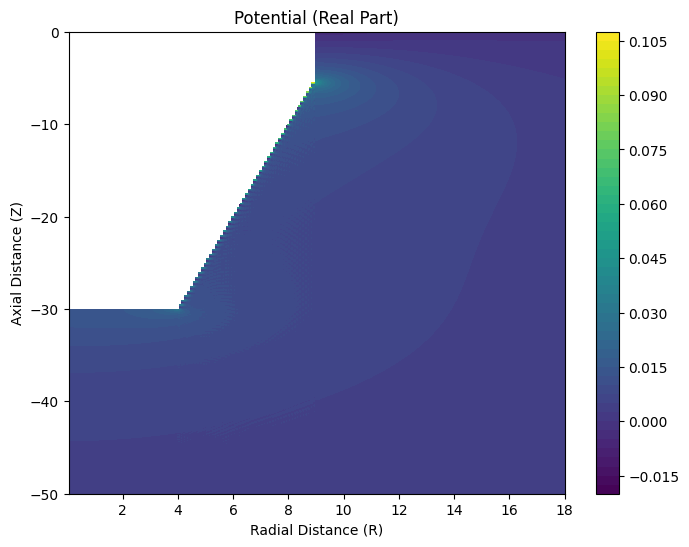

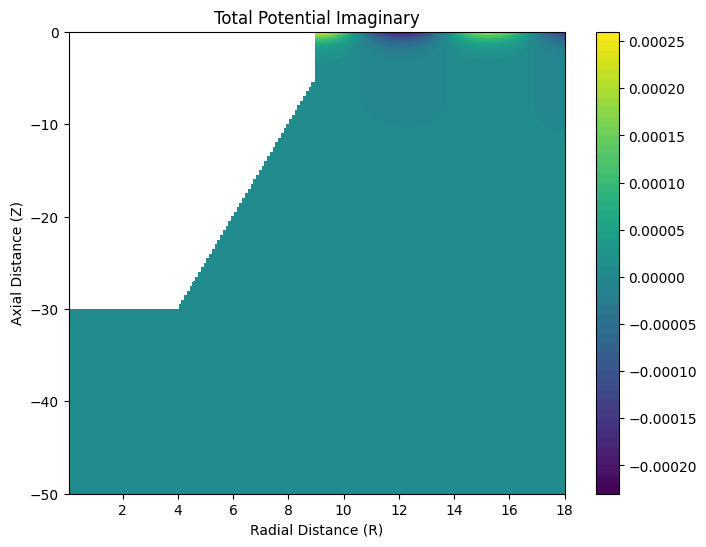

In [24]:
x5, cs5, p5 = solve_problem(SProblem3, h, a, d_in, d_out, heaving, m0, rho, 50, 2)
p5.plot_potentials(cs5, res = 400)